### 对于这个七分类图像问题，采用了Resnet18网络结构，最终得到在训练集上97.7%, 测试集上94.0%的准确率，并用训练好的模型对一些案例图片进行分类，分类效果良好。

### 主体模型：Resnet，未划分验证集

### 模型重要参数：batch_size=16,kernel_size=10,lr, num_epochs= 0.2, 50, CrossEntropyLoss,SGD

### 实验环境：python=3.8、d2l=0.17.4、matplotlib=3.4.0、numpy=1.22.2、pandas=1.2.4、torch=1.10.2+cu113、torchvision=0.11.3+cull3,RTX2060


#### 1.导入包

In [1]:
from torchvision.datasets import ImageFolder
import torchvision
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

#### 2.  图片的增广
对train和test采取不同的aug，test上仅仅只进行标准化和resize，而对于train上本文共进行三种变换：左右翻转、颜色的对比度，亮度，色调的浮动、切割

In [2]:
shape_aug = transforms.RandomResizedCrop((224, 224),
                                         scale=(0.4, 1),
                                         ratio=(1, 1))  #切割
color_aug = transforms.ColorJitter(brightness=0.3,
                                   contrast=0,
                                   saturation=0,
                                   hue=0)  #色彩
train_augs = transforms.Compose([
    transforms.Resize([512, 512]),
    transforms.RandomHorizontalFlip(),  #左右翻转
    color_aug,
    shape_aug,
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])  #标准化

test_augs = transforms.Compose([
    transforms.Resize([224, 224]),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])  #标准化

#### 3.数据导入

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


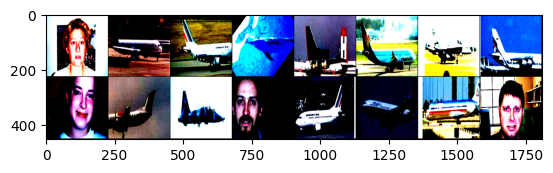

In [3]:
train_path = r'C:/Users/86198/Desktop/pictures/pictures/image/train'

data_train = datasets.ImageFolder(train_path, transform=train_augs)

train_data_loader = DataLoader(data_train,
                               batch_size=16,
                               shuffle=True,
                               drop_last=True)

for i, data in enumerate(train_data_loader):
    images, labels = data

    # 打印数据集中的图片
    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


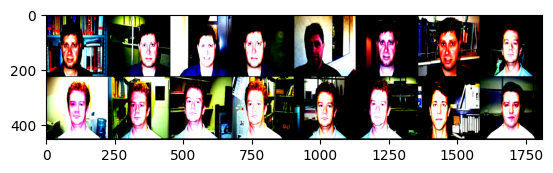

In [4]:
test_path = r'C:/Users/86198/Desktop/pictures/pictures/image/test'

data_test = datasets.ImageFolder(test_path, transform=test_augs)

test_data_loader = DataLoader(data_test,
                              batch_size=16,
                              shuffle=False,
                              drop_last=False)

for i, data in enumerate(test_data_loader):
    images, labels = data

    # 打印数据集中的图片
    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

    break

#### 4.主体模型

In [5]:
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save

    def __init__(self,
                 input_channels,
                 num_channels,
                 use_1x1conv=False,
                 strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,
                               num_channels,
                               kernel_size=3,
                               padding=1,
                               stride=strides)
        self.conv2 = nn.Conv2d(num_channels,
                               num_channels,
                               kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels,
                                   num_channels,
                                   kernel_size=1,
                                   stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [6]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=10, stride=2, padding=0),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
def resnet_block(input_channels,
                 num_channels,
                 num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels,
                         num_channels,
                         use_1x1conv=True,
                         strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [8]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [9]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 7))

In [10]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device


# 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
def train(net, train_iter, test_iter, num_epochs, lr, device):

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)  #优化器采用SGB
    #optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',
                            xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

#### 5.训练

loss 0.076, train acc 0.977, test acc 0.940
231.5 examples/sec on cuda:0


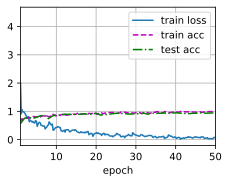

In [14]:
lr, num_epochs = 0.1, 50
train_iter = train_data_loader
test_iter = test_data_loader
train(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

#### 6.模型的保存，并验证一些图片

In [24]:
torch.save(net, 'Resnet.pth')

cup


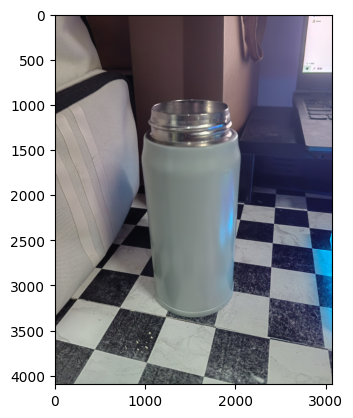

In [30]:
import PIL.Image

image_path = "C:/Users/86198/Desktop/pictures/pictures/image/unknown6.jpg"
image = PIL.Image.open(image_path)
plt.imshow(image)
img = train_augs(image)
model = torch.load("Resnet.pth", map_location=torch.device('cpu'))
img = torch.reshape(img, (1, 3, 224, 224))
model.eval()
with torch.no_grad():
    output = model(img)
print(train_data_loader.dataset.classes[int(output.argmax(1))])